# Georgia

Now it's time to look into Georgia. Like the two other states we've looked at so far, Georgia also saw a major increase in cases.  The difference here, however, was that their numbers were not nearly as high.  Let's see how that affects our models.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import helper_functions
from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import create_dataset
from helper_functions import fit_model
from helper_functions import test_RMSE
from helper_functions import train_RMSE
# from helper_functions import preprocess_data
from helper_functions import plot_loss
from helper_functions import LSTM_prediction_plot
import pmdarima as pm

Using TensorFlow backend.


Once again, we'll load this helper function for use later.

In [2]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''

    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test

# SARIMA Model

Once again we'll load our data and check out its plot.

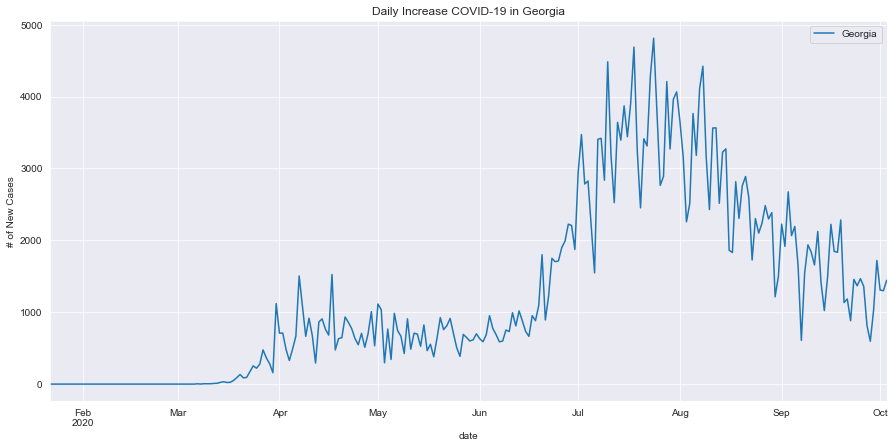

In [3]:
df = pd.read_csv('national_positive_increase.csv')

df = pd.read_csv('national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# Georgia
ga = df['GA_positiveIncrease']
ga.plot(figsize=(15, 7), label='Georgia')

plt.ylabel('# of New Cases')
plt.title('Daily Increase COVID-19 in Georgia')
plt.legend()
plt.show();


Again, the plot clearly shows exponential trends, and we'll be able to calculate differencing through grid search. Let's just go ahead and find values for `p` , `q`, and `s`.

## ACF and PACF

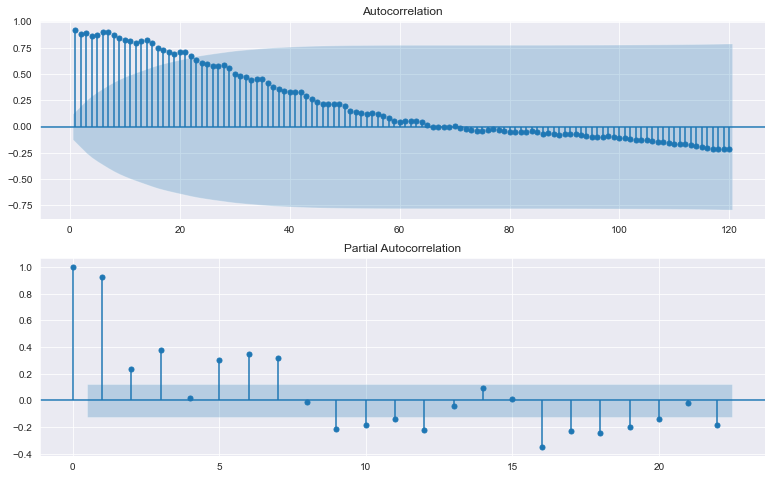

In [4]:
acf_pacf(ga)

These plots are very similar to the other states.  This time, however, the AR(`p`) order is around 4 lags and the MA(`q`) is up to 19.

## Seasonality

Time to find out our seasonality.

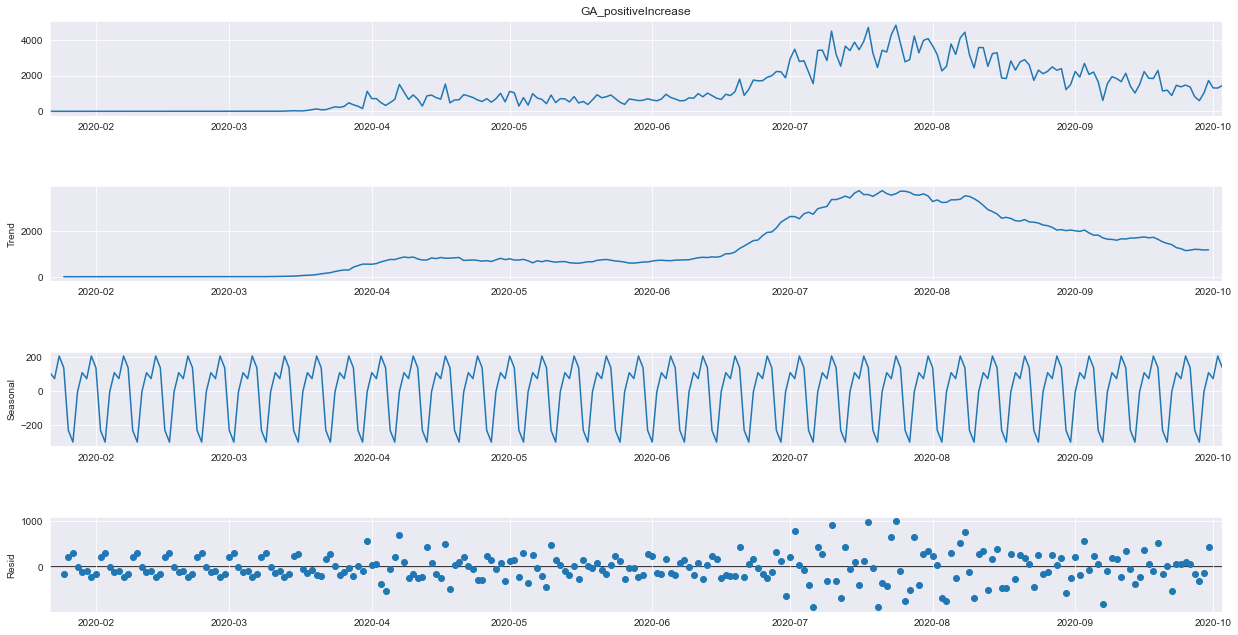

In [5]:
decompose_time_series(ga)

Again, we're seeing similarities between California and Florida (I have a feeling that this will be a theme).  The seasonality is still weekly and the trend is exponentially positive and then a more gradual decrease. The residuals stay pretty normal at first, but unlike the California and Florida, it starts becoming heteroskedastic in April.  Then the residuals seem to be more evenly distributed, just with greater variance until the summer months.  After each instance of heteroskedasticity comes a period where the residuals try to be more normally distributed, but they never quite return to what they were in the beginning.    

Now that we have our parameters, it's time for Auto-ARIMA

## Grid Search

In [6]:
ga_results = pm.auto_arima(ga, information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=4, max_q=22,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
ga_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=3743.143, BIC=3764.391, Fit time=0.877 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=3877.888, BIC=3884.971, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=3838.104, BIC=3852.269, Fit time=0.270 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=3795.912, BIC=3810.077, Fit time=0.421 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=3794.228, BIC=3811.934, Fit time=0.569 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=3741.415, BIC=3766.204, Fit time=1.278 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 0, 7); AIC=3749.280, BIC=3770.528, Fit time=0.797 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=3765.204, BIC=3793.534, Fit time=1.472 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=3777.824, BIC=3795.530, Fit time=0.508 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 1, 7), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

Optimal order for Georgia is (1, 1, 2) and the seasonal order is (2, 0, 1, 7).  The AIC score for this combination is 3727.303, a little less complex than Florida.

Let's split up the data now.

## Train-Test Split

In [7]:
ga_train, ga_test = train_test(ga)

## Model Fitting

                                      SARIMAX Results                                      
Dep. Variable:                 GA_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 7)   Log Likelihood               -1484.701
Date:                             Thu, 15 Oct 2020   AIC                           2983.403
Time:                                     15:43:41   BIC                           3006.630
Sample:                                 01-22-2020   HQIC                          2992.798
                                      - 08-13-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8446      0.059    -14.260      0.000      -0.961      -0.729
ma.L1          0.2519      

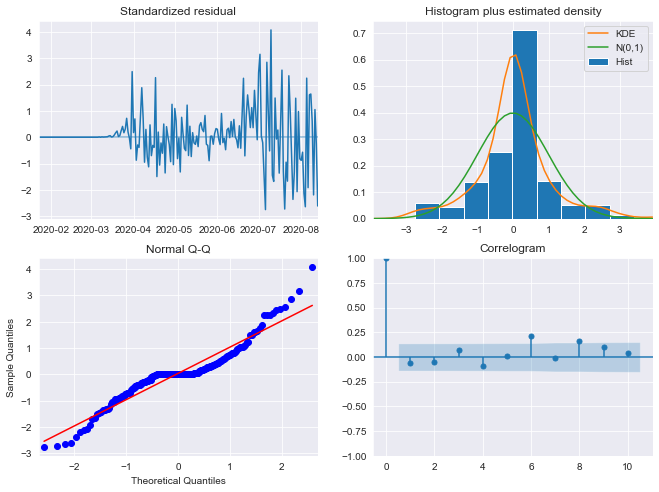

In [9]:
pdq = (1, 1, 2)
pdqs = (2, 0, 1, 7)
results = fit_model(ga_train, pdq=pdq, pdqs=pdqs)

## Results

It's a lot easier to see what I mentioned about residuals.  After every episode of heteroskedasticity, the residuals become farther from the mean. The QQ-Plot is probably the best we've seen so far. The histogram is still leptokurtic, but it is better than Florida's.

Let's check out the RMSE and the prediction plots.

### RMSE and Predictions

SARIMA model RMSE on train data: 582.00243


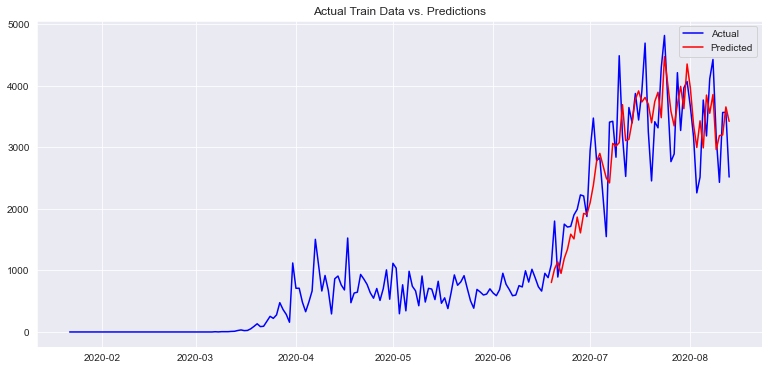

In [14]:
train_RMSE(ga_train, results, display = True)

SARIMA model RMSE on test data: 359.50285


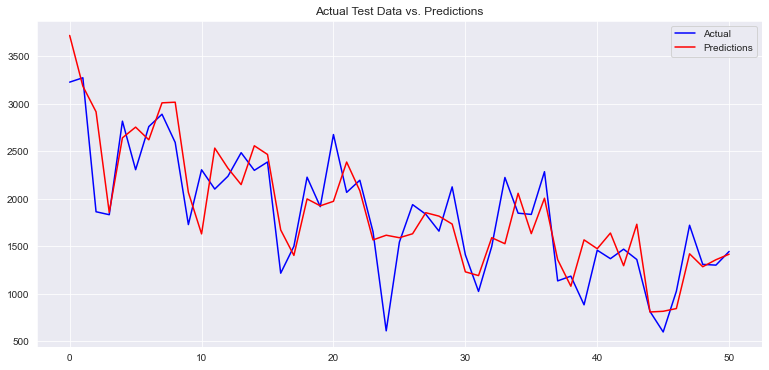

In [13]:
test_RMSE(ga_train, ga_test, pdq, pdqs, display=True)

* Train RMSE: 582.002
* Test RMSE: 359.503

Wow! As far as RMSE goes, it's going to be difficult to beat these.  Again the prediction plots aren't very tight, but they get the general trend.

Let's get a forecast!

## October Forecast

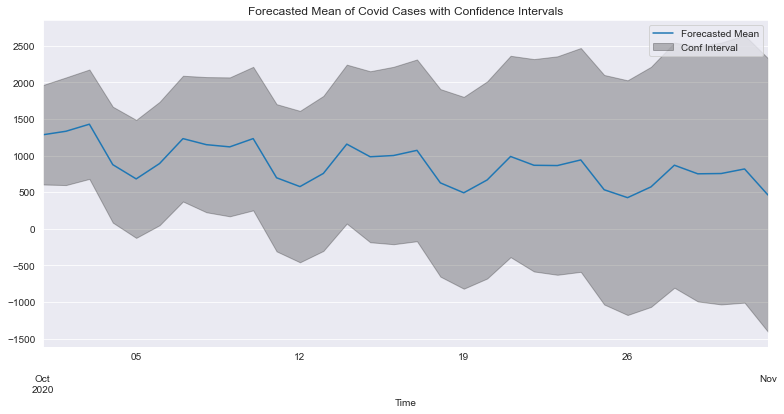

In [21]:
model = sm.tsa.statespace.SARIMAX(ga, order=pdq, seasonal_order=pdqs)
fit_model = model.fit()
output = fit_model.get_prediction(start='2020-10-01',end='2020-11-01', dynamic=True)
forecast_ci = output.conf_int()
fig, ax = plt.subplots(figsize=(13,6))
output.predicted_mean.plot(label='Forecasted Mean')
ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
plt.title('Forecasted Mean of Covid Cases with Confidence Intervals')
plt.xlabel('Time')
plt.legend(loc='best');
plt.show()

Once again, the mean estimate predictions are decreasing gradually.  Again looking at the New York Times, on October 5th, Georgia reported 741 new cases. The prediction generated by the forecast is almost spot on.  This accuracy is short lived, however, because the forecast for the 12th was around 600 and the actual reported number was 906. To be fair, this forecast is only showing the mean of the predictions. It is not making concrete predictions. 

Let's see if we can make better predictions with LSTMs again.

# LSTM

## Splitting and Preprocessing

In [15]:
ga_train, ga_val, ga_test = preprocess_data(ga, 'GA_positiveIncrease')

print(f"Train has {len(ga_train)} values")
print(f"Validation has {len(ga_val)} values")
print(f"Test has {len(ga_test)} values")

Train has 235 values
Validation has 7 values
Test has 14 values


## Reshape

In [16]:
look_back = 1

X_train, y_train = create_dataset(ga_train, look_back)
X_val, y_val = create_dataset(ga_val, look_back)
X_test, y_test = create_dataset(ga_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Model Fitting

In [17]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100)], 
                    verbose=1, shuffle=False)

model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 3ms/step - loss: 0.1427 - val_loss: 0.1261
Epoch 2/500
233/233 [==============================] - 0s 73us/step - loss: 0.1323 - val_loss: 0.1151
Epoch 3/500
233/233 [==============================] - 0s 77us/step - loss: 0.1236 - val_loss: 0.1046
Epoch 4/500
233/233 [==============================] - 0s 82us/step - loss: 0.1154 - val_loss: 0.0946
Epoch 5/500
233/233 [==============================] - 0s 69us/step - loss: 0.1069 - val_loss: 0.0853
Epoch 6/500
233/233 [==============================] - 0s 124us/step - loss: 0.0993 - val_loss: 0.0765
Epoch 7/500
233/233 [==============================] - 0s 133us/step - loss: 0.0932 - val_loss: 0.0683
Epoch 8/500
233/233 [==============================] - 0s 86us/step - loss: 0.0860 - val_loss: 0.0607
Epoch 9/500
233/233 [==============================] - 0s 94us/step - loss: 0.0809 - val_loss: 0.0537
Epoch 10/500
233/233 [===============

Epoch 80/500
233/233 [==============================] - 0s 103us/step - loss: 0.0144 - val_loss: 0.0073
Epoch 81/500
233/233 [==============================] - 0s 73us/step - loss: 0.0140 - val_loss: 0.0073
Epoch 82/500
233/233 [==============================] - 0s 73us/step - loss: 0.0134 - val_loss: 0.0073
Epoch 83/500
233/233 [==============================] - 0s 73us/step - loss: 0.0135 - val_loss: 0.0073
Epoch 84/500
233/233 [==============================] - 0s 69us/step - loss: 0.0133 - val_loss: 0.0074
Epoch 85/500
233/233 [==============================] - 0s 60us/step - loss: 0.0132 - val_loss: 0.0074
Epoch 86/500
233/233 [==============================] - 0s 73us/step - loss: 0.0124 - val_loss: 0.0074
Epoch 87/500
233/233 [==============================] - 0s 77us/step - loss: 0.0122 - val_loss: 0.0075
Epoch 88/500
233/233 [==============================] - 0s 64us/step - loss: 0.0123 - val_loss: 0.0075
Epoch 89/500
233/233 [==============================] - 0s 51us/step - l

In [18]:
from sklearn.metrics import mean_absolute_error as MAE

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale for interpretation
train_predict = scaler.inverse_transform(train_predict)
y_train_rescaled = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                               train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                       test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                              test_predict[:,0])))

Train Mean Absolute Error: 340.5466049914708
Train Root Mean Squared Error: 480.4707347153528
Test Mean Absolute Error: 276.74420166015625
Test Root Mean Squared Error: 349.0859076435626


* Train RMSE: 480.471
* Test RMSE: 349.086

I don't know how the model did it, but it still managed to decrease training RMSE from 582 to 480, and test RMSE also slightly improved.  We'll if the predictions are any better.

First, we'll look at the model loss. 

## Model Loss

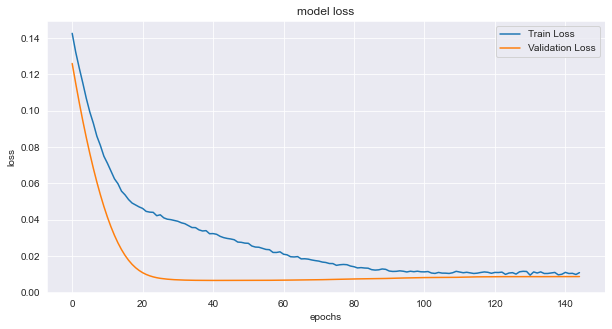

In [19]:
plot_loss(history)

Wow! The train loss and validation loss got really close this time around.  They both managed to converge it seems, so I don't see a reason to train any longer. 

## Prediction
Finally, our prediction plot.

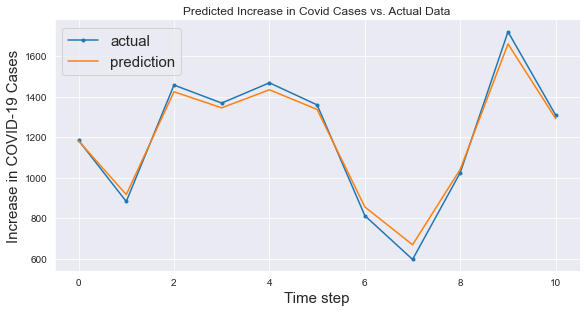

In [20]:
LSTM_prediction_plot(test_predict, y_test_rescaled)

It's crazy how big of a change can be made with just a little drop the RMSE.